# Data Analysis
Given Python model is developed to more focuses on Data Analysis part, it has less GUI features.

In [1]:
import time, random, pickle
import pandas as pd

# call all the modules of the model
from modules import *

# every time the windpark_model is instantiated, it runs until 2050
def windpark_model(seed):
    random.seed(seed)
    m = Model()
    m.setup()
    for _ in range(32):
        m.update()
    windspeed, invest_year, subsidy_at_invest = np.round(m.investors_profile[m.investors_profile["invested"]][["type", "windspeed", "invest_year", "subsidy at invest year"]].mean(), 2)
    invest_perc = m.investors_profile["invested"].value_counts(True)[True]
    result = invest_perc, windspeed, invest_year, subsidy_at_invest
    return m, result

# for example, create 12 instances with different random seeds
seeds = range(12)

In [2]:
# single run
m = windpark_model(0)[0]

# multiple run in parallel -> the result is already saved
# from multiprocessing import Pool

# s1 = time.time()
# pool = Pool(processes=12)
# multi_models = []

# for result in pool.map(windpark_model, seeds):
#     multi_models.append(result)
# e1 = time.time()
# print("multi:", e1-s1)

In [3]:
# load the data of 600 investors' behaviors
data = pd.read_csv("base_scen_data.csv")

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Overview 1 - Investments
- How does the investment increase over time?

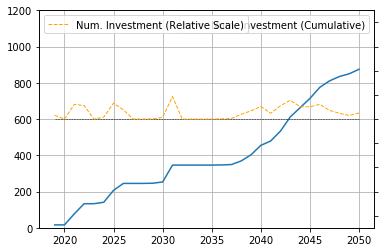

In [5]:
inv = dict(zip(range(2019, 2051), np.zeros(32)))
inv.update(data["invest_year"].value_counts().sort_index().loc[:2050].to_dict())
inv = pd.Series(inv)
fig, ax = plt.subplots()
ax.plot(inv.cumsum(), label="Num. Investment (Cumulative)")
ax.set_ylim(0, 1200)
ax.grid()
ax3 = ax.twinx()
ax3.plot(inv, color="orange", linestyle="--", linewidth=1, label="Num. Investment (Relative Scale)")
ax3.hlines(y=0, xmin=2019, xmax=2050, linestyle="--", linewidth=.5)
ax3.set_ylim(-450, 450)
ax3.set_yticklabels("")
ax.legend(loc=1)
ax3.legend(loc=2)

## Overview 2 - Composition
- How the composition of agents who make investment looks like?

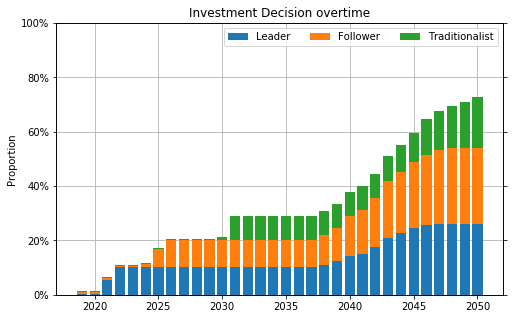

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = np.random.random(size=(12, 3))
ax2 = ax.twinx()

df_invested = data[data["invested"]].copy()
df_invested[["type", "invest_year"]]
df = pd.DataFrame(index=np.arange(2019, 2051), columns=["L", "F", "T"])
for row in df.iterrows():
    year = row[0]
    for t in ["L", "F", "T"]:
        row[1][t] = np.count_nonzero((df_invested["type"] == t) & (df_invested["invest_year"] == year))
    df.loc[year] = row[1]
df = df.cumsum()/1200

ax2.bar(df.index, df["L"], label="Leader")
ax2.bar(df.index, df["F"], bottom=df["L"], label="Follower")
ax2.bar(df.index, df["T"], bottom=df["L"] + df["F"], label = "Traditionalist")

ax.set_ylim(0, 1)
ax2.set_ylim(0, 1)

ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels(labels=[s + "%" for s in np.linspace(0, 100, 6, dtype=int).astype(str)])
ax.set_ylabel("Proportion")
ax.set_title("Investment Decision overtime")
ax2.legend(loc=0, ncol=3)
ax2.set_yticklabels("")
ax.grid()

## Overview 3 - Regulator
- How the regulator decrease the emission by raising subsidy to promote investment?

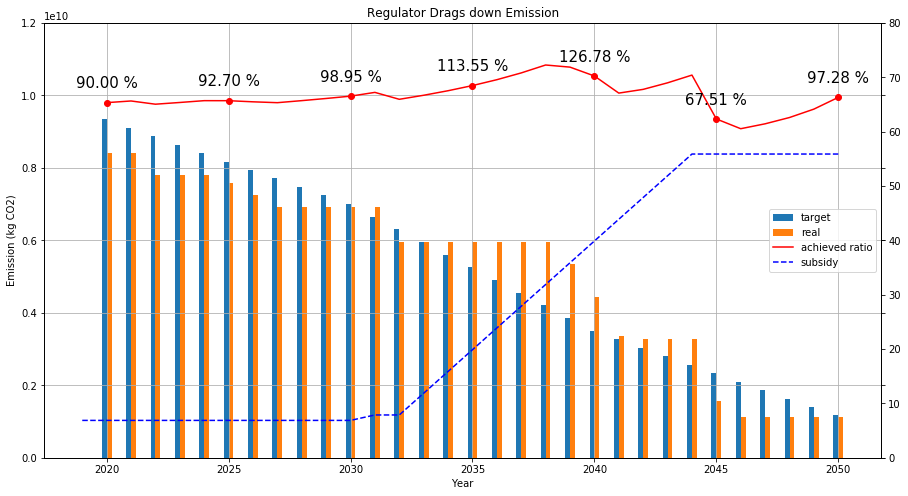

In [7]:
x = np.arange(2020, 2051)

fig, ax = plt.subplots(figsize=(15, 8))
target = m.regulator.comparison["target"][:2050]
achieved = m.regulator.comparison["achieve"][:2050]

bar1 = ax.bar(target.index-.1, target, width=.2, label="target")
bar2 = ax.bar(achieved.index+.1, achieved, width=.2, label="real")
ax.set_ylim(0, 1.2e10)


ax2 = ax.twinx()
trend = achieved / target
line = ax2.plot(trend, color="r", label="achieved ratio")
scatter = ax2.scatter(trend[::5].index, trend[::5], color="r")
for year, text in trend[::5].to_dict().items():
    ax2.text(x = year, y = text+.2, s = "%.2f %%"%(text*100), size = 15, horizontalalignment='center')
ax2.set_ylim(-4, 2)
ax2.set_yticklabels("")

ax3 = ax.twinx()
ax3.plot(m.subsidy_overtime.keys(), m.subsidy_overtime.values(), color="blue", linestyle="--", label="subsidy")
ax3.set_ylim(0, 80)

# add all objects
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()

ax.legend(h1+h2+h3, l1+l2+l3, loc=5)
ax.set_ylabel("Emission (kg CO2)")
ax.set_xlabel("Year")
ax.set_title("Regulator Drags down Emission")
ax.grid()

## Overview 4 - Investors who actually invested
- What is the mutual features shared among investors?

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


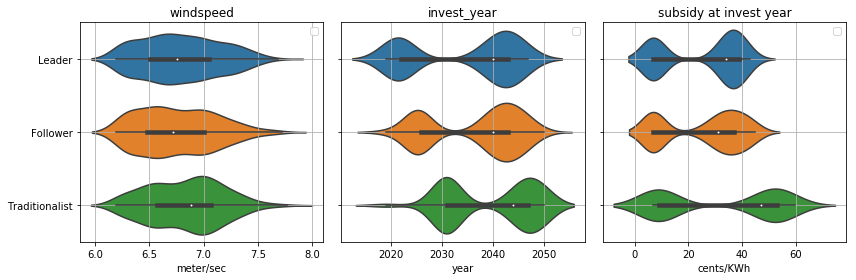

In [8]:
def f1(x):
    col = "estimation_%s"%(x[0])
    try:
        return x[col].strip("(").strip(")").split(",")[0]
    except:
        return 0
    
def f2(x):
    col = "estimation_%s"%(x[0])
    try:
        return x[col].strip("(").strip(")").split(",")[1]
    except:
        return 0

data["npv at investment"] = data.iloc[:, 9:].apply(f1, axis=1).astype(float)
data["ROI at investment"] = data.iloc[:, 9:].apply(f2, axis=1).astype(float)

drop_col = [col for col in data.columns if "estimation" in col]
data.drop(drop_col, axis=1, inplace=True)

data["capacity(cat)"] = data["capacity"].apply(lambda x: "large" if x >= 35 else "small")

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), sharey=True)
units = ["meter/sec", "year", "cents/KWh"]
for i, param in enumerate(["windspeed", "invest_year", "subsidy at invest year"]):
    ax = axes[i]
    sns.violinplot(x=param, y="type", data=data[data["invested"]], orient="h", ax=ax)
    ax.set_title(param)
    ax.set_xlabel(units[i])
    ax.set_ylabel("")
    ax.set_yticklabels(["Leader", "Follower", "Traditionalist"])
    ax.grid()
    ax.legend("")
fig.tight_layout()

In [9]:
data[data["invested"]][["windspeed", "invest_year", "subsidy at invest year"]].mean()

windspeed                    6.786195
invest_year               2036.419429
subsidy at invest year      26.980571
dtype: float64

## Individual Level 1 - Windspeed
- How strong the windspeed's impact is?

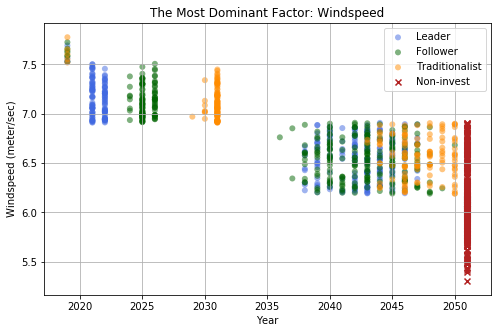

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = "royalblue", "darkgreen", "darkorange"
labels = "Leader", "Follower", "Traditionalist"
markers = "o", "x"
for i, b in enumerate([True, False]):
    da = data[data["invested"] == b]
    marker = markers[i]
    for j, t in enumerate(data["type"].unique()):
        d = da[da["type"] == t]
        y = "windspeed"
        if b:
            c = colors[j]
            ax.scatter(d["invest_year"], d[y], marker = marker, color=c, edgecolor="none", label=labels[j], alpha=.5)
        else:
            c = "firebrick"
            if j != 0:
                label = ""
            else:
                label = "Non-invest"
            ax.scatter(d["invest_year"], d[y], marker = "x", color=c, label=label, alpha=1)
ax.legend()
ax.set_ylabel("Windspeed (meter/sec)")
ax.set_xlabel("Year")
ax.set_title("The Most Dominant Factor: Windspeed")
ax.grid()
ax.legend()

In [11]:
# average windspeed of investors who doesn't invest
data[data["invested"] == False]["windspeed"].mean()

6.1417501827613314

## Individual Level 2 - Windspeed threshold
- What is the minimum condition of windspeed?

[]

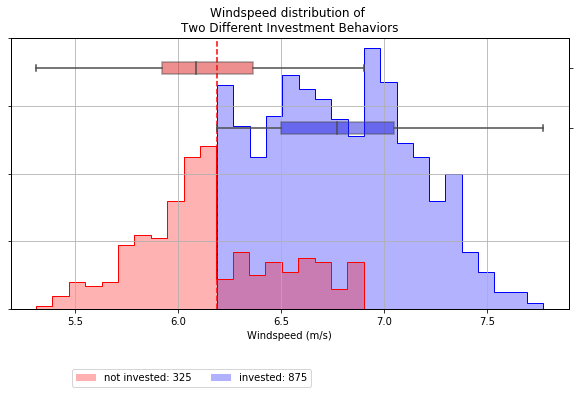

In [12]:
from scipy import stats
colors=["blue", "red"]
labels=["invested", "not invested"]
labels = np.char.array(labels) + ": " + data["invested"].value_counts().values.astype(str)
handles=[]
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()
ax3 = ax.twinx()
for i, b in enumerate([True, False]):
    x = data[data["invested"] == b]["windspeed"]
    color = colors[i]
    label = labels[i]
    kde = stats.gaussian_kde(x)
    xx = np.linspace(5, 8, 1000)
    
    ax.hist(x, histtype="step", bins=20, color=color, alpha=1)
    ax.hist(x, histtype="stepfilled", bins=20, color=color, alpha=0.3)
    if not b:
        ax_ = ax2
    else:
        ax_ = ax3
    sns.boxplot(x, color=color, ax=ax_)
    plt.setp(ax_.artists, alpha=.5)
ax.set_ylim(0, 80)
ax2.set_ylim(-16, 2)
ax3.set_ylim(-12, 6)
handles = ax.get_legend_handles_labels()[0]
ax.legend([handles[3], handles[1]], labels[::-1], bbox_to_anchor=(.1, -.2), loc=2, ncol=2)
ax.grid()
ax.vlines(x=6.19, ymin=0, ymax=80, color="red", linewidth=1.5, linestyle="--")
ax.set_xlabel("Windspeed (m/s)")
ax.set_title("Windspeed distribution of \nTwo Different Investment Behaviors")
ax.set_yticks(np.linspace(0, 80, 5))
ax.set_yticklabels("")

## Individual Level 3 - Subsidy
- Is subsidy influential?

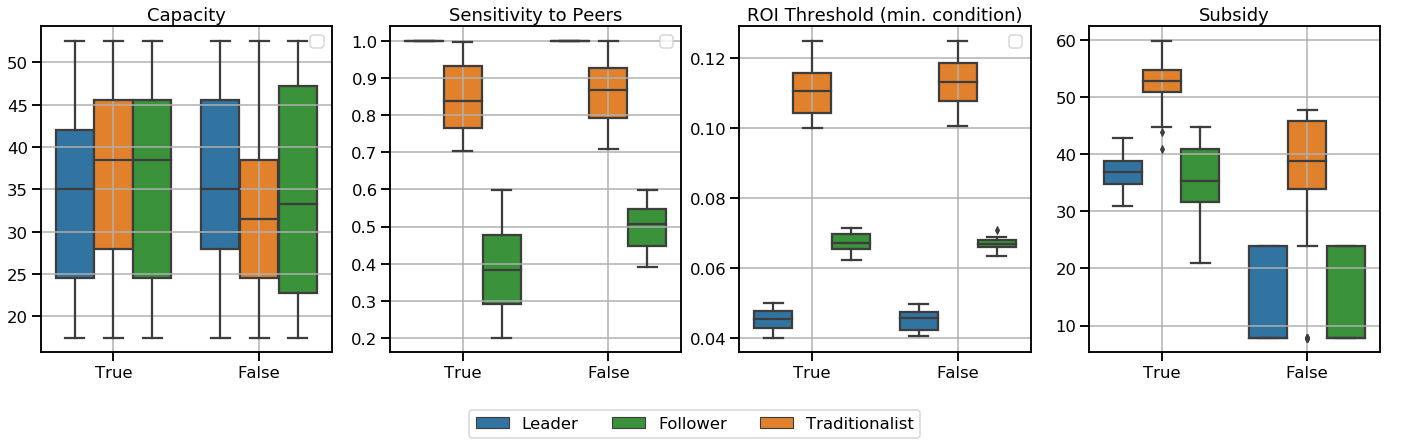

In [13]:
sns.set_context("talk")
params = ["windspeed", "capacity", "sen-to-peers", "thresh", "subsidy at invest year"][1:]
titles = ["Wind speed", "Capacity", "Sensitivity to Peers", "ROI Threshold (min. condition)", "Subsidy"][1:]
fig, axes = plt.subplots(figsize=(24, 6), ncols=len(params))

d = data[(data["invest_year"] > 2035) & (data["windspeed"] > 6.19)]

for i, ax in enumerate(axes):
    param = params[i]
    title = titles[i]
    plt.setp(ax.artists, alpha=.3)
    
    ax2 = ax.twinx()
    sns.boxplot(x="invested", y=param, order = [True, False], hue="type", data=d, ax=ax)
    ax.legend("")
    ax2.axis("off")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid()
    ax.set_title(title)
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[2], handles[1]], ["Leader", "Follower", "Traditionalist"], ncol=3, bbox_to_anchor=(-.55, -.15))

In [14]:
data["invest_year"] = data["invest_year"].apply(lambda x: 2060 + random.randint(-5, 5) if x == 2051 else x)
data["windspeed(cat)"] = data["windspeed"].apply(lambda x: "high" if x > 7.5 else
                                                 "medium" if x > 6.19 else
                                                 "low")

## Individual Level 4 - Irrelevant factors
- How other factors are influential apart from windspeed and subsidy?

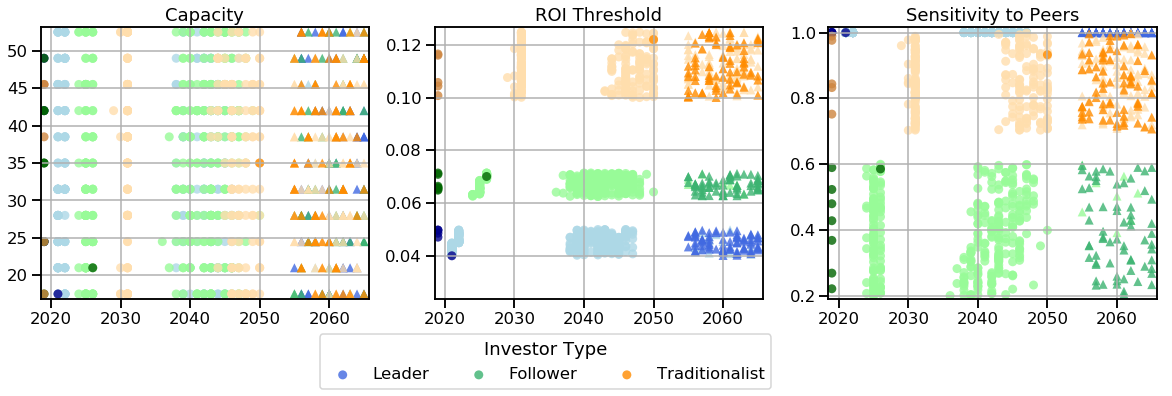

In [15]:
sns.set_context("talk")
params = ["subsidy at invest year", "capacity", "thresh", "sen-to-peers"][1:]
titles = ["Subsidy", "Capacity", "ROI Threshold", "Sensitivity to Peers"][1:]

fig, axes = plt.subplots(figsize=(20, 5), ncols=len(params))
colors = [
    ("lightblue", "royalblue", "darkblue"),
    ("palegreen", "mediumseagreen", "darkgreen"),
    ("navajowhite", "darkorange", "peru"),
]

markers = "o", "^"
dots = []

for h, ax in enumerate(axes[:]):
    param = params[h]
    for i, b in enumerate([True, False]):
        dat = data[data["invested"] == b]
        marker = markers[i]
        edgecolor = ["none", "none"][i]
        for j, t in enumerate(data["type"].unique()):
            da = dat[dat["type"] == t]
            color = colors[j]
            for k, w in enumerate(data["windspeed(cat)"].unique()):
                d = da[da["windspeed(cat)"] == w]
                col = color[k]
                dot = ax.scatter(d["invest_year"], d[param], marker = marker, color=col, edgecolor=edgecolor, alpha=.8)
                if k == 1 and b:
                    dots.append(dot)
    ax.grid()
    ax.set_title(titles[h])
    ax.autoscale(tight=True)
ax.legend(dots, ["Leader", "Follower", "Traditionalist"], title="Investor Type", ncol=3, bbox_to_anchor=(-.15, -0.1))